<a href="https://colab.research.google.com/github/SRISUDIV/Demand-forecasting-for-logistics/blob/main/XGBoost_Time_Series_Forecasting_for_Grocery_Sales_in_Stores_in_Ecuador.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'store-sales-time-series-forecasting:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F29781%2F2887556%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240830%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240830T142911Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D486a6f52fd8aa62f9206ef1c1f3c32e1928ab8d2a3103f004aa4e4d81fcc3fa4a6b3740c4d9c4fd00abd0c4aae2705aa129c9e4a7b27774d669b547d86f03f4262555697e0e19d9cb3e3924ef1b801b85e10e565f9b28f9241277ff0ce87f63613ddffe0fdd7445071effd42e1ae74638268303dfd1b18161f8dc705cf21c4c4f52eb1bcf93ac607c39eb5b6cb702cd6e66221f213c488af4f323f9626648e46244da55f12157b4e4101c5fabe9c6100268a2b72f560396077c8f0a8cd87ab0b4b6a17b182e4e7fafc165814856a9b2e409f80e5664d5e8356cc1a6db2edc60e5b610cd1e19b61d1b982ee29539f7e7bc0a367c413ec462a18e910036ac2b53e'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


In [ ]:
# !pip install pandas
# !pip install xgboost

In [ ]:
import os

import inspect
import time
import warnings
import calendar

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
from sklearn.metrics import mean_squared_log_error
from sklearn.preprocessing import LabelEncoder
import pytz
import scipy.stats as stats
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
import optuna
from xgboost import plot_importance

warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.filterwarnings("ignore")

In [ ]:
def cal_rmlse(y_true, y_pred):
    """
    Calculate the Root Mean Logarithmic Squared Error (RMLSE).

    :param y_true: Array of true values
    :param y_pred: Array of predicted values
    :return: RMLSE value
    """
    # Ensure the predictions are positive
    y_pred = np.clip(y_pred, 0, None)

    # Calculate Mean Squared Logarithmic Error
    msle = mean_squared_log_error(y_true, y_pred)

    # Calculate the Root Mean Logarithmic Squared Error
    rmlse = np.sqrt(msle)

    return rmlse

# Data Preparation

## Importing the Datasets

In [ ]:
def wrangle(filepath):
    # Read CSV file
    df = pd.read_csv(filepath)
    # Change the date to `datetime` type
    df["date"] = pd.to_datetime(df["date"])

    return df

In [ ]:
train_data = wrangle('/kaggle/input/store-sales-time-series-forecasting/train.csv')
test_data = wrangle('/kaggle/input/store-sales-time-series-forecasting/test.csv')

In [ ]:
oil=wrangle("/kaggle/input/store-sales-time-series-forecasting/oil.csv")
stores=pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/stores.csv")
transactions=pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/transactions.csv")
holidays=wrangle("/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv")

In [ ]:
# Aggregate data for training
train_data = train_data.groupby(['date', 'store_nbr', 'family']).agg({
        'sales': 'sum',
        'onpromotion': 'sum'
    }).reset_index()
# Aggregate data for testing
test_data = test_data.groupby(['date', 'store_nbr', 'family']).agg({
        'onpromotion': 'sum'
    }).reset_index()

## Explore

### Train and Test Data

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 5 columns):
 #   Column       Dtype         
---  ------       -----         
 0   date         datetime64[ns]
 1   store_nbr    int64         
 2   family       object        
 3   sales        float64       
 4   onpromotion  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 114.5+ MB


The date changed  to `datetime` object for easier manipulation of time series data.

In [ ]:
train_data.head()

,date,store_nbr,family,sales,onpromotion
0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,2013-01-01,1,BABY CARE,0.0,0
2,2013-01-01,1,BEAUTY,0.0,0
3,2013-01-01,1,BEVERAGES,0.0,0
4,2013-01-01,1,BOOKS,0.0,0


In [ ]:
test_data.head()

,date,store_nbr,family,onpromotion
0,2017-08-16,1,AUTOMOTIVE,0
1,2017-08-16,1,BABY CARE,0
2,2017-08-16,1,BEAUTY,2
3,2017-08-16,1,BEVERAGES,20
4,2017-08-16,1,BOOKS,0


In [ ]:
train_data.isnull().sum()

date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

I believe that we are incredibly lucky that there seems to be no missing values

In [ ]:
train_data.nunique()

date             1684
store_nbr          54
family             33
sales          379610
onpromotion       362
dtype: int64

It seems like we need bar charts/histograms to better explore store_nbr and family and
need boxplots and histograms for exploring sales

In [ ]:
train_data[["sales", "onpromotion"]].describe()

,sales,onpromotion
count,3.000888e+06,3.000888e+06
mean,3.577757e+02,2.602770e+00
std,1.101998e+03,1.221888e+01
min,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00
50%,1.100000e+01,0.000000e+00
75%,1.958473e+02,0.000000e+00
max,1.247170e+05,7.410000e+02


As we can see, although the dataset has no failed data point (no data point falling under 0), the mean for both `sales` and `onpromotion` is much larger than the median (the 50% quartile).
To understand this, we need to see how house sizes are distributed in our dataset.
Let's look at two ways to visualize the distribution: a histogram and a boxplot.

#### store_nbr

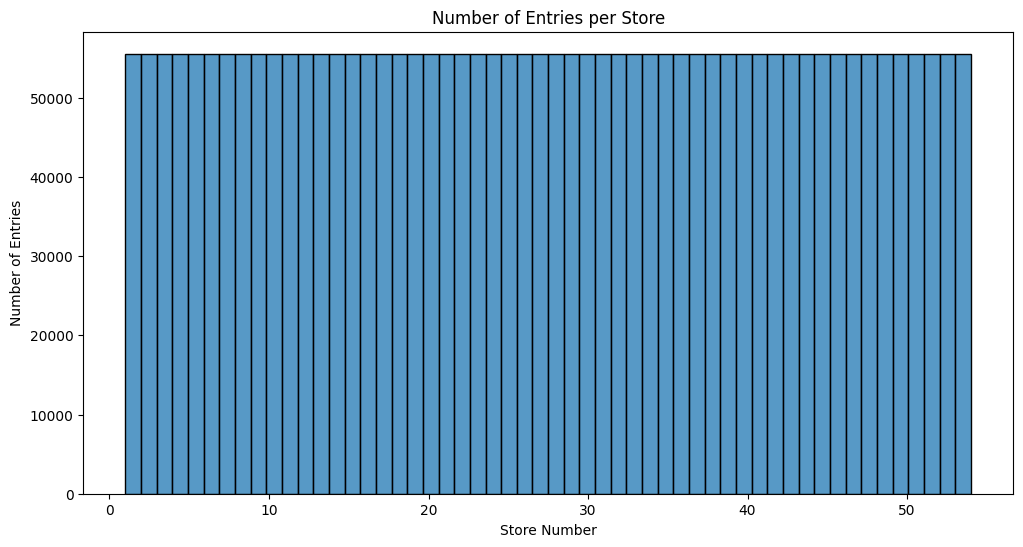

In [ ]:
plt.figure(figsize=(12, 6))

sns.histplot(train_data["store_nbr"], bins=len(train_data["store_nbr"].unique()), kde=False)
plt.title("Number of Entries per Store")
plt.xlabel("Store Number")
plt.ylabel("Number of Entries")
plt.show()

Data collection was evenly distributed across all stores.

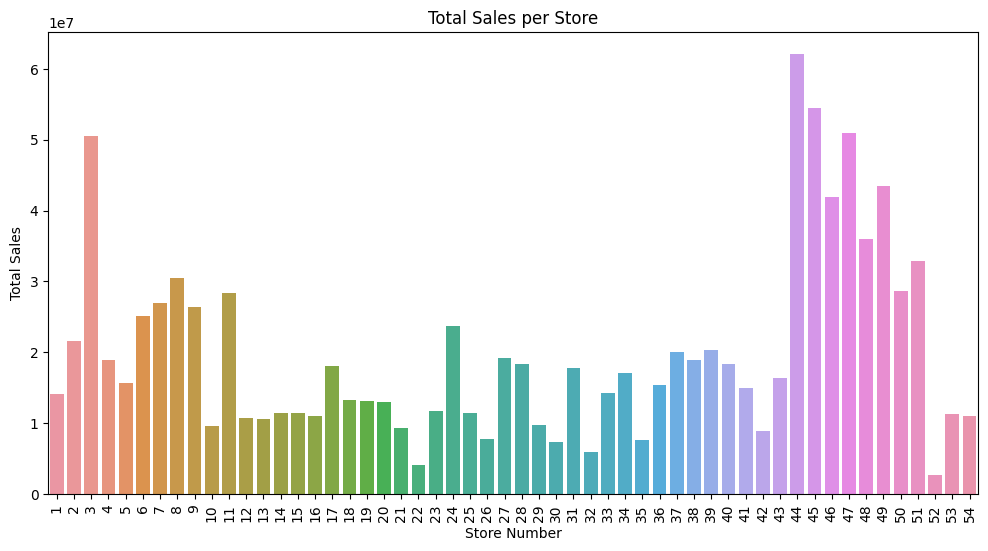

In [ ]:
# Calculate total sales per store
total_sales_per_store = train_data.groupby("store_nbr")["sales"].sum()

# Plotting total sales per store
plt.figure(figsize=(12, 6))
sns.barplot(x=total_sales_per_store.index, y=total_sales_per_store.values)
plt.title("Total Sales per Store")
plt.xlabel("Store Number")
plt.ylabel("Total Sales")
plt.xticks(rotation=90)
plt.show()
del total_sales_per_store

There seems to be differences in revenue generated across different stores though
Despite having the same number of data points, some stores generate much higher sales values than others. This variation could be due to several factors, such as store location, customer demographics, store size, product variety, pricing strategies, etc.

#### family

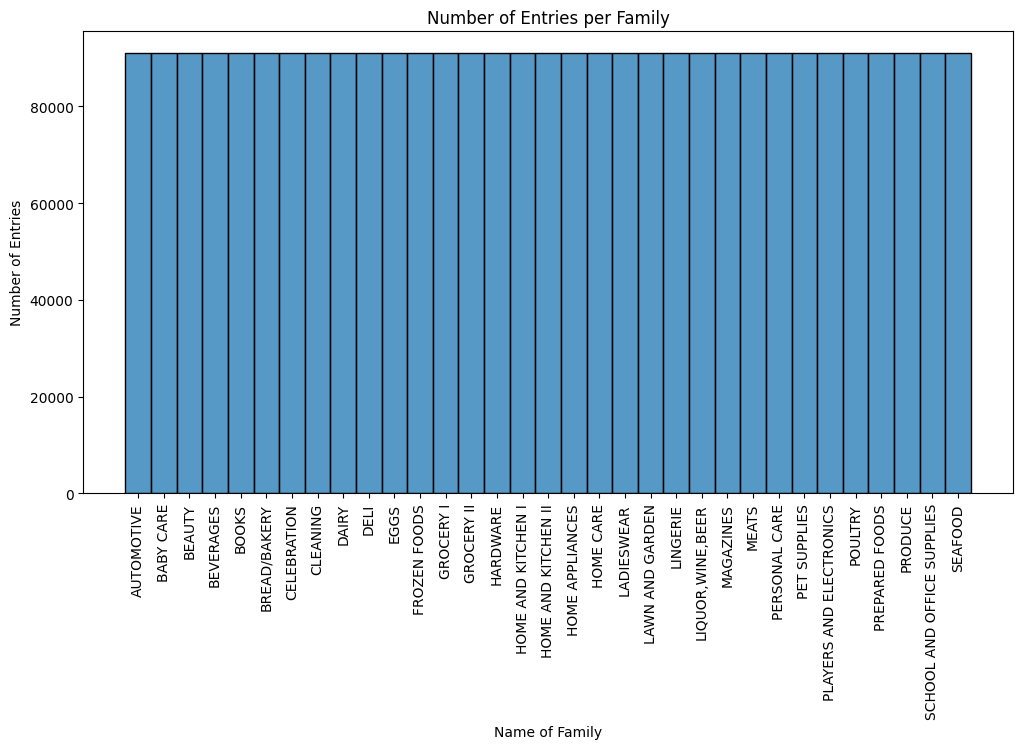

In [ ]:
plt.figure(figsize=(12, 6))
sns.histplot(train_data["family"], bins=len(train_data["family"].unique()), kde=False)
plt.title("Number of Entries per Family")
plt.xlabel("Name of Family")
plt.ylabel("Number of Entries")
plt.xticks(rotation=90)
plt.show()

Similarly, data collection seems to be very evenly distributed for Family

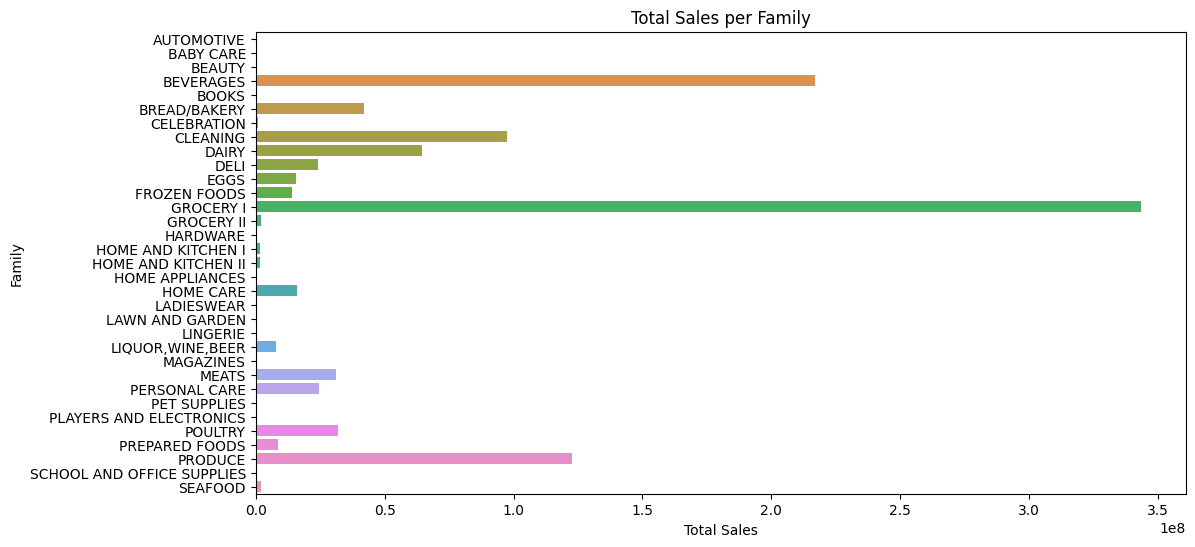

In [ ]:
# Calculate total sales per family
total_sales_per_family = train_data.groupby("family")["sales"].sum()

# Plotting total sales per family
plt.figure(figsize=(12, 6))
sns.barplot(x=total_sales_per_family.values, y=total_sales_per_family.index, orient='h')
plt.title("Total Sales per Family")
plt.xlabel("Total Sales")
plt.ylabel("Family")
plt.show()
del total_sales_per_family

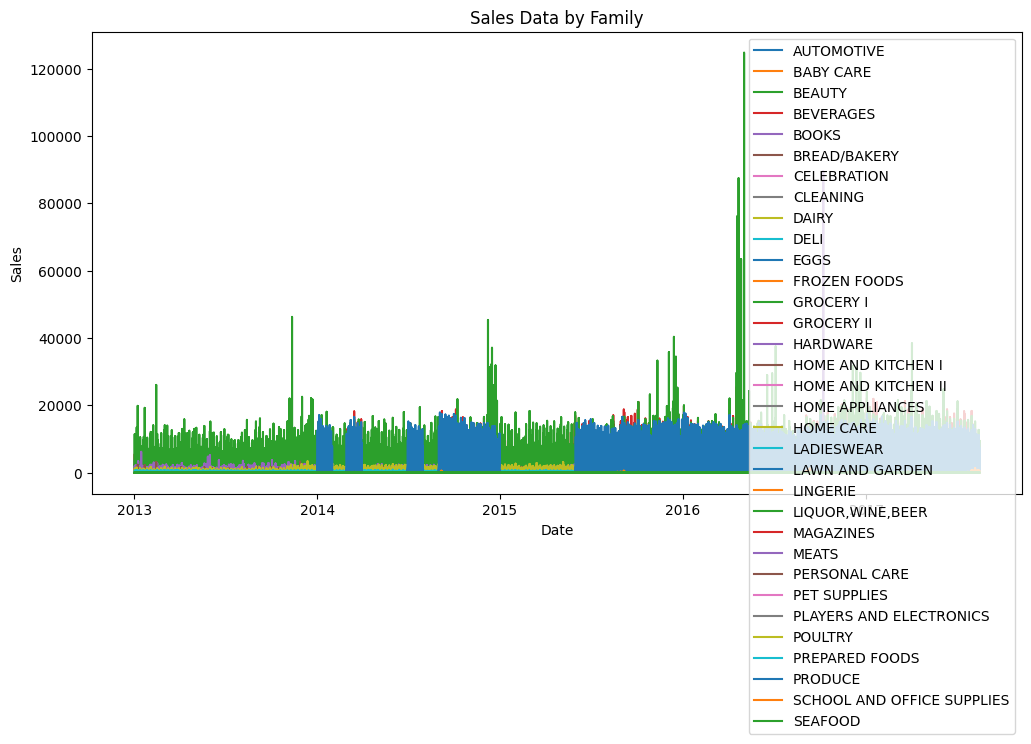

In [ ]:
# Trend in Sales per Family
plt.figure(figsize=(12, 6))
for family in train_data['family'].unique():
    family_data = train_data[train_data['family'] == family]
    family_data.set_index('date', inplace=True)
    plt.plot(family_data.index, family_data['sales'], label=family)
plt.legend()
plt.title('Sales Data by Family')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()
del family_data

There seems to be a lot of changes throughout the course of the timeline. Seems like we need to cut and only train for the latter part of the data since many of the families weren't there to begin with in the first place

### Additional datasets

In [ ]:
oil.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [ ]:
stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [ ]:
print(oil.isnull().sum())

date           0
dcoilwtico    43
dtype: int64


In [ ]:
transactions.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [ ]:
print(stores.isnull().sum())

store_nbr    0
city         0
state        0
type         0
cluster      0
dtype: int64


In [ ]:
holidays.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [ ]:
print(transactions.isnull().sum())

date            0
store_nbr       0
transactions    0
dtype: int64


### Data Preprocessing

Seems like we need to deal with the oil price data

In [ ]:
def preprocess_oil(oil):
    oil['month'] = oil['date'].dt.to_period('M')
    oil['month_avg'] = oil.groupby('month')['dcoilwtico'].transform('mean')
    oil['tmp'] = oil['dcoilwtico'].isna()
    oil['month_avg'] = oil['tmp'] * oil['month_avg']
    oil['dcoilwtico'].fillna(0, inplace=True)
    oil['dcoilwtico'] = oil['dcoilwtico'] + oil['month_avg']
    oil = oil.drop(['month', 'month_avg', 'tmp'], axis=1)
    return oil

oil = preprocess_oil(oil)

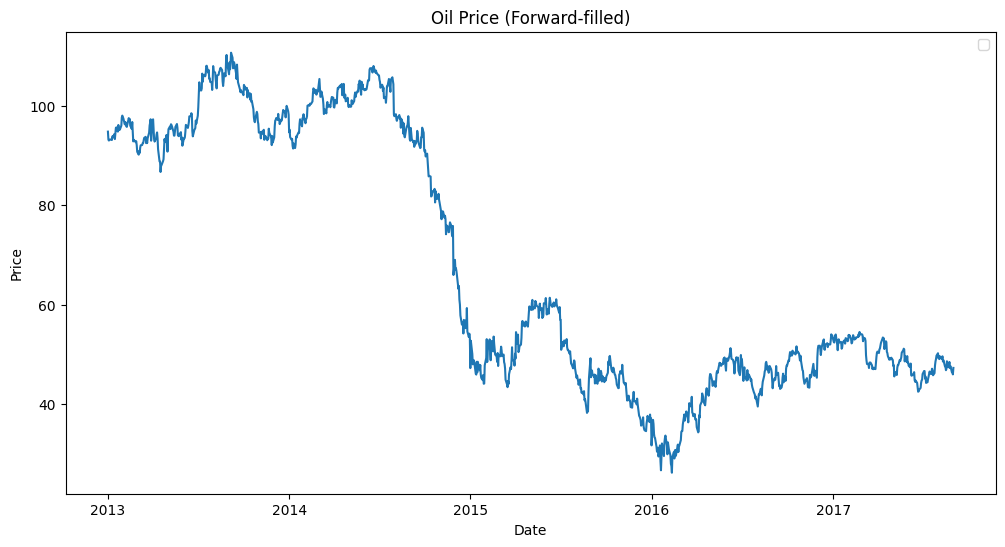

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(oil["date"], oil["dcoilwtico"])
plt.legend()
plt.title('Oil Price (Forward-filled)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

Similarly, I think I need to train the model on only the latter part of the data

### Data Transforming

Join the different datasets into one single dataset for extra features

In [ ]:
# Merge datasets
train_data = train_data.merge(stores, how='left', on='store_nbr')
train_data = train_data.merge(oil, how='left', on='date')
train_data = train_data.merge(holidays, how='left', on='date')
# Apply the same feature engineering steps to the test data
test_data = test_data.merge(stores, how='left', on='store_nbr')
test_data = test_data.merge(oil, how='left', on='date')
test_data = test_data.merge(holidays, how='left', on='date')

In [ ]:
train_data.isnull().sum()

date                 0
store_nbr            0
family               0
sales                0
onpromotion          0
city                 0
state                0
type_x               0
cluster              0
dcoilwtico      878526
type_y         2551824
locale         2551824
locale_name    2551824
description    2551824
transferred    2551824
dtype: int64

Drop uneeded columns

In [ ]:
columns_to_drop = ['type_x', 'locale', 'locale_name', 'description', 'transferred']
train_data = train_data.drop(columns=columns_to_drop)
test_data = test_data.drop(columns=columns_to_drop)

Feature engineering for date - since XGBoost cannot directly capture this data type, we have to create these features

In [ ]:
# Add custom features for train data
def add_custom_features(df):
    df['date'] = pd.to_datetime(df['date'])  # Ensure 'date' column is datetime type
    df['weekday'] = df['date'].dt.weekday
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['eomd'] = df['date'].apply(lambda x: calendar.monthrange(x.year, x.month)[1])
    df['payday'] = ((df['day'] == 15) | (df['day'] == df['eomd'])).astype(int)
    df['is_weekend'] = df['weekday'].isin([5, 6]).astype(int)
    df.drop(['eomd'], axis=1, inplace=True)  # Drop unnecessary columns
    return df

# Apply custom features to both train and test data
train_data = add_custom_features(train_data)
test_data = add_custom_features(test_data)

In [ ]:
# # Add lag features for lag 7 and lag 30
# train_data['sales_lag_7'] = train_data.groupby(['store_nbr', 'family'])['sales'].shift(7)
# train_data['sales_lag_30'] = train_data.groupby(['store_nbr', 'family'])['sales'].shift(30)
# test_data['sales_lag_7'] = test_data.groupby(['store_nbr', 'family'])['onpromotion'].shift(7)
# test_data['sales_lag_30'] = test_data.groupby(['store_nbr', 'family'])['onpromotion'].shift(30)

# # Fill missing values after shifting
# train_data.fillna(0, inplace=True)
# test_data.fillna(0, inplace=True)

In [ ]:
def add_lag_features(df, lags):
    for lag in lags:
        df[f'sales_lag_{lag}'] = df.groupby(['store_nbr', 'family'])['sales'].transform(lambda x: x.shift(lag))
    return df

In [ ]:
def add_rolling_mean_features(df, windows):
    for window in windows:
        df[f'sales_roll_mean_{window}'] = df.groupby(['store_nbr', 'family'])['sales'].transform(
            lambda x: x.shift(1).rolling(window=window, min_periods=1).mean()) + add_random_noise(df)
    return df

In [ ]:
def add_ewm_features(df, alphas, lags):
    for alpha in alphas:
        for lag in lags:
            df[f'sales_ewm_alpha_{str(alpha).replace(".", "")}_lag_{lag}'] = df.groupby(['store_nbr', 'family'])['sales'].transform(
                lambda x: x.shift(lag).ewm(alpha=alpha).mean())
    return df

In [ ]:
def add_random_noise(df):
    return np.random.normal(scale=2.0, size=(len(df),))

In [ ]:
train_data.tail()

,date,store_nbr,family,sales,onpromotion,city,state,cluster,dcoilwtico,type_y,weekday,year,month,day,payday,is_weekend
3054343,2017-08-15,54,POULTRY,59.619,0,El Carmen,Manabi,3,47.57,Holiday,1,2017,8,15,1,0
3054344,2017-08-15,54,PREPARED FOODS,94.000,0,El Carmen,Manabi,3,47.57,Holiday,1,2017,8,15,1,0
3054345,2017-08-15,54,PRODUCE,915.371,76,El Carmen,Manabi,3,47.57,Holiday,1,2017,8,15,1,0
3054346,2017-08-15,54,SCHOOL AND OFFICE SUPPLIES,0.000,0,El Carmen,Manabi,3,47.57,Holiday,1,2017,8,15,1,0
3054347,2017-08-15,54,SEAFOOD,3.000,0,El Carmen,Manabi,3,47.57,Holiday,1,2017,8,15,1,0


As we can see, the categorical columns that need encoding are: family, city, state, type_y, cluster, store_nbr

In [ ]:
test_data.head()

,date,store_nbr,family,onpromotion,city,state,cluster,dcoilwtico,type_y,weekday,year,month,day,payday,is_weekend
0,2017-08-16,1,AUTOMOTIVE,0,Quito,Pichincha,13,46.8,NaN,2,2017,8,16,0,0
1,2017-08-16,1,BABY CARE,0,Quito,Pichincha,13,46.8,NaN,2,2017,8,16,0,0
2,2017-08-16,1,BEAUTY,2,Quito,Pichincha,13,46.8,NaN,2,2017,8,16,0,0
3,2017-08-16,1,BEVERAGES,20,Quito,Pichincha,13,46.8,NaN,2,2017,8,16,0,0
4,2017-08-16,1,BOOKS,0,Quito,Pichincha,13,46.8,NaN,2,2017,8,16,0,0


In [ ]:
del oil
del stores
del transactions
del holidays

In [ ]:
# Concatenate train and test datasets
data = pd.concat([train_data, test_data], axis=0, ignore_index=True)

In [ ]:
# Specify the lags, rolling windows, and EWM parameters
lags = [7, 14, 30]
windows = [7, 30]
ewm_alphas = [0.95, 0.9, 0.8]
ewm_lags = [7, 30]

# Apply lag features
data = add_lag_features(data, lags)

# Apply rolling mean features
data = add_rolling_mean_features(data, windows)

# Apply EWM features
data = add_ewm_features(data, ewm_alphas, ewm_lags)

In [ ]:
data.fillna(0, inplace=True)

In [ ]:
#Split back into train and test data
train_data = data[data['date'] <= '2017-08-15'].copy()
test_data = data[data['date'] > '2017-08-15'].copy()

In [ ]:
# List of categorical features to encode
cat_features = ['family', 'city', 'state', 'type_y', 'cluster', 'store_nbr']

train_data_encoded = train_data
test_data_encoded = test_data

# Ensure all values in categorical columns are of string type
train_data_encoded[cat_features] = train_data_encoded[cat_features].astype(str)
test_data_encoded[cat_features] = test_data_encoded[cat_features].astype(str)

# Apply Label Encoding
label_encoders = {}
for col in cat_features:
    le = LabelEncoder()
    train_data_encoded[col] = le.fit_transform(train_data[col])
    test_data_encoded[col] = le.transform(test_data[col])
    label_encoders[col] = le

In [ ]:
del train_data

In [ ]:
train_data_encoded.head()

,date,store_nbr,family,sales,onpromotion,city,state,cluster,dcoilwtico,type_y,...,sales_lag_14,sales_lag_30,sales_roll_mean_7,sales_roll_mean_30,sales_ewm_alpha_095_lag_7,sales_ewm_alpha_095_lag_30,sales_ewm_alpha_09_lag_7,sales_ewm_alpha_09_lag_30,sales_ewm_alpha_08_lag_7,sales_ewm_alpha_08_lag_30
0,2013-01-01,0,0,0.0,0,18,12,4,94.756667,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2013-01-01,0,1,0.0,0,18,12,4,94.756667,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2013-01-01,0,2,0.0,0,18,12,4,94.756667,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2013-01-01,0,3,0.0,0,18,12,4,94.756667,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2013-01-01,0,4,0.0,0,18,12,4,94.756667,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
test_data_encoded.nunique()

date                             16
store_nbr                        54
family                           33
sales                             1
onpromotion                     212
city                             22
state                            16
cluster                          17
dcoilwtico                       12
type_y                            2
weekday                           7
year                              1
month                             1
day                              16
payday                            2
is_weekend                        2
sales_lag_7                    3838
sales_lag_14                   6981
sales_lag_30                   7877
sales_roll_mean_7             12475
sales_roll_mean_30            28512
sales_ewm_alpha_095_lag_7     11908
sales_ewm_alpha_095_lag_30    26903
sales_ewm_alpha_09_lag_7      11956
sales_ewm_alpha_09_lag_30     27139
sales_ewm_alpha_08_lag_7      12010
sales_ewm_alpha_08_lag_30     27348
dtype: int64

In [ ]:
# Drop the original categorical columns since they are now encoded
train_data_encoded.drop(['date'], axis=1, inplace=True)
test_data_encoded.drop(['date'], axis=1, inplace=True)

In [ ]:
# Calculate the correlation matrix
correlation_matrix = train_data_encoded.corr()

# Extract the correlation with the 'sales' column
correlation_with_sales = correlation_matrix['sales']

In [ ]:
# Use the absolute values of the correlations
abs_correlation_with_sales = correlation_with_sales.abs()

# Get summary statistics for the absolute correlation with 'sales'
correlation_summary = abs_correlation_with_sales.describe()

# Print the summary statistics
print(correlation_summary)

count    26.000000
mean      0.460926
std       0.434118
min       0.000826
25%       0.050164
50%       0.271114
75%       0.926502
max       1.000000
Name: sales, dtype: float64


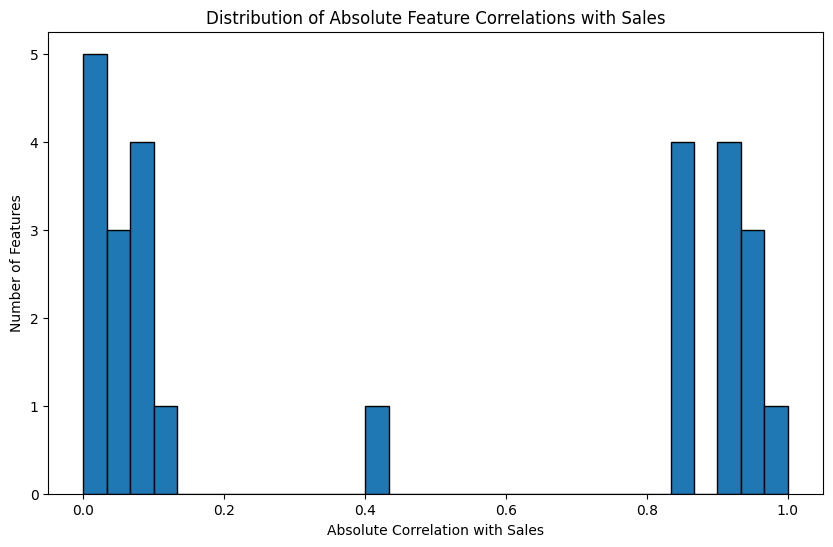

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(abs_correlation_with_sales, bins=30, edgecolor='black')
plt.title('Distribution of Absolute Feature Correlations with Sales')
plt.xlabel('Absolute Correlation with Sales')
plt.ylabel('Number of Features')
plt.show()

In [ ]:
# low_correlation_threshold = 0.01

# # Identify features with correlation below
# low_correlation_features = abs_correlation_with_sales[abs_correlation_with_sales <= low_correlation_threshold]

# # Print the features with the low correlation
# print("Features with low correlation to 'sales':")
# print(low_correlation_features)

In [ ]:
# # Drop low-correlation features from the dataset
# train_data_encoded = train_data_encoded.drop(columns=low_correlation_features.index)

In [ ]:
# # Drop only the features that exist in the test dataset
# common_features = low_correlation_features.index.intersection(test_data_encoded.columns)
# test_data_encoded = test_data_encoded.drop(columns=common_features)

## Split

In [ ]:
# Define the target and features
X = train_data_encoded.drop(columns=['sales'])
y = train_data_encoded['sales']

# Model Building

## Bayesyan Optuna Test

Perform a bayesyan optuna test to find the best hyper param combo. This is performed on the last 20% of the data

In [ ]:
# Assuming train_data_encoded is your preprocessed DataFrame sorted by time
subset_frac = 0.20
subset_size = int(len(train_data_encoded) * subset_frac)
subsample_train_data = train_data_encoded.iloc[-subset_size:]

In [ ]:
# Split features and target
X_subsample = subsample_train_data.drop(columns=["sales"])
y_subsample = subsample_train_data["sales"]

In [ ]:
# Time-based train-validation split within the subset
split_index = int(0.8 * len(X_subsample))
X_sub_train, X_sub_val = X_subsample.iloc[:split_index], X_subsample.iloc[split_index:]
y_sub_train, y_sub_val = y_subsample.iloc[:split_index], y_subsample.iloc[split_index:]

In [ ]:
# Define the Optuna objective function
def objective(trial):
    params = {
        # 'tree_method': 'gpu_hist',
        'tree_method': 'hist',
        'n_jobs': -1,
        'objective': 'reg:squarederror',
        'n_estimators': trial.suggest_int('n_estimators', 100, 300),
        'verbosity': 2,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'max_depth': trial.suggest_int('max_depth', 6, 14),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 10, 24),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.001, 1, log=True),
        'colsample_bynode': trial.suggest_float('colsample_bynode', 0.3, 0.9)
    }

    model = xgb.XGBRegressor(**params)

    model.fit(X_sub_train, y_sub_train, eval_set=[(X_sub_val, y_sub_val)], early_stopping_rounds=10, verbose=False)
    y_pred = model.predict(X_sub_val)
    rmse = mean_squared_error(y_sub_val, y_pred, squared=False)
    return rmse

In [ ]:
# Create and optimize the study
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

[I 2024-08-30 13:53:20,154] A new study created in memory with name: no-name-8e0c0e74-7a65-475c-8cf3-1827a32ff793
[I 2024-08-30 13:53:28,247] Trial 0 finished with value: 265.9229525405118 and parameters: {'n_estimators': 204, 'learning_rate': 0.058163819376272116, 'max_depth': 7, 'subsample': 0.9105166559272806, 'colsample_bytree': 0.9191325516539315, 'min_child_weight': 12, 'reg_lambda': 0.38887326331194283, 'colsample_bynode': 0.7314944208054527}. Best is trial 0 with value: 265.9229525405118.
[I 2024-08-30 13:53:44,167] Trial 1 finished with value: 260.3169542060036 and parameters: {'n_estimators': 178, 'learning_rate': 0.04507632602952603, 'max_depth': 14, 'subsample': 0.6573685480734993, 'colsample_bytree': 0.3062367602519679, 'min_child_weight': 11, 'reg_lambda': 0.0010313814457363153, 'colsample_bynode': 0.43752946711258744}. Best is trial 1 with value: 260.3169542060036.
[I 2024-08-30 13:54:05,400] Trial 2 finished with value: 277.25941607517797 and parameters: {'n_estimators'

In [ ]:
# Print the best parameters
best_params_optuna = study.best_params
print(f"Best parameters found with Optuna: {best_params_optuna}")

Best parameters found with Optuna: {'n_estimators': 153, 'learning_rate': 0.023651230305093564, 'max_depth': 13, 'subsample': 0.6486315747658347, 'colsample_bytree': 0.9713831702706509, 'min_child_weight': 24, 'reg_lambda': 0.0019081767751734566, 'colsample_bynode': 0.3389273169234641}


## Model retrain with the best parameters (Still only using the last 20% of the dataset)

In [ ]:
# Retrain the final model on the full dataset with the best parameters
final_model = xgb.XGBRegressor(**best_params_optuna)

Fit the model

# Submission

## Model re-run on full dataset

In [ ]:
# Train on the full dataset
# final_model = xgb.XGBRegressor(**best_params_optuna)
final_model.fit(X_subsample, y_subsample, verbose=True)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=0.3389273169234641,
             colsample_bytree=0.9713831702706509, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.023651230305093564, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=13, max_leaves=None,
             min_child_weight=24, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=153, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
test_data_encoded.head()

,store_nbr,family,onpromotion,city,state,cluster,dcoilwtico,type_y,weekday,year,...,sales_lag_14,sales_lag_30,sales_roll_mean_7,sales_roll_mean_30,sales_ewm_alpha_095_lag_7,sales_ewm_alpha_095_lag_30,sales_ewm_alpha_09_lag_7,sales_ewm_alpha_09_lag_30,sales_ewm_alpha_08_lag_7,sales_ewm_alpha_08_lag_30
3054348,0,0,0,18,12,4,46.8,0,2,2017,...,4.0,2.0,0.205373,7.896342,6.857370e+00,2.009781,6.728925e+00,2.038480,6.511056e+00,2.151308
3054349,0,1,0,18,12,4,46.8,0,2,2017,...,0.0,0.0,-4.801548,-2.221419,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000
3054350,0,2,2,18,12,4,46.8,0,2,2017,...,2.0,5.0,6.604357,4.073367,3.907132e+00,4.857144,3.827138e+00,4.727317,3.698718e+00,4.501235
3054351,0,3,20,18,12,4,46.8,0,2,2017,...,2645.0,2381.0,1757.715942,2072.429468,2.315387e+03,2318.700769,2.317378e+03,2262.147948,2.312079e+03,2166.967588
3054352,0,4,0,18,12,4,46.8,0,2,2017,...,0.0,1.0,-3.156069,-1.342633,1.855469e-12,0.950238,9.000000e-10,0.901801,4.096000e-07,0.812851


## Make predictions on the test dataset

In [ ]:
print(set(final_model.get_booster().feature_names) - set(X.columns))

set()


In [ ]:
test_data_encoded = test_data_encoded[X.columns]

In [ ]:
# Predict on the test data
y_test_pred = final_model.predict(test_data_encoded)
y_test_pred = np.clip(y_test_pred, 0, None)

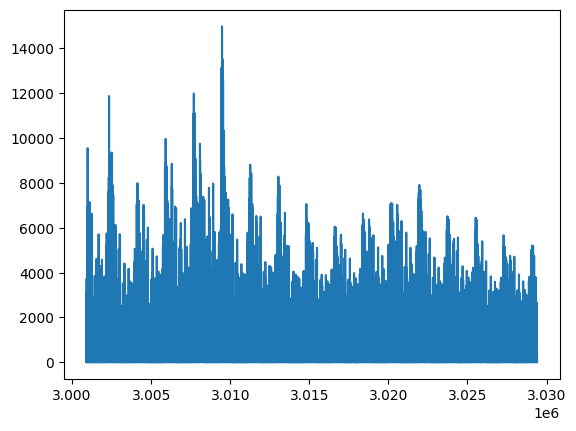

In [ ]:
plt.plot(test_data['id'],y_test_pred)
plt.xlabel("Data Point ID")
plt.ylabel("Predicted future Sales")
plt.title("Fuu")